##### Figure 3

# HRRR forecast (single) with MesoWest Observations

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd, wind_spddir_to_uv

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b-%d\n%H:%M')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [two_column, 4]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .2
mpl.rcParams['grid.alpha'] = .8
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 600    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


## Initial Setup
Station ID, lat/lon grid, pluck HRRR point

In [3]:
# Get Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [4]:
stn = 'HWKC1'

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

## Retrieve HRRR forecasts data

In [5]:
# Model run time
DATE = datetime(2017, 10, 9, 0)

TMP = point_hrrr_pollywog(DATE, 'TMP:2 m', lat=MWlat, lon=MWlon, verbose=False)
RH = point_hrrr_pollywog(DATE, 'RH:2 m', lat=MWlat, lon=MWlon, verbose=False)
UV10 = point_hrrr_pollywog(DATE, 'UVGRD:10 m', lat=MWlat, lon=MWlon, verbose=False)
UV80 = point_hrrr_pollywog(DATE, 'UVGRD:80 m', lat=MWlat, lon=MWlon, verbose=False)

Point Pollywog: Finished with multiprocessing in 0:00:02.357190 on 22 processors.
Point Pollywog: Finished with multiprocessing in 0:00:01.965501 on 22 processors.
Point Pollywog: Finished with multiprocessing in 0:00:08.512073 on 22 processors.
Point Pollywog: Finished with multiprocessing in 0:00:09.773397 on 22 processors.


## Retrieve Observational data from MesoWest

In [6]:
# Get Mesowest Observed Value
a = get_mesowest_ts(stn, DATE-timedelta(hours=1), DATE+timedelta(hours=18))

# Use wind speed and direction to derive U and V values
MWu, MWv = wind_spddir_to_uv(a['wind_speed'], a['wind_direction'])

## Create Figure

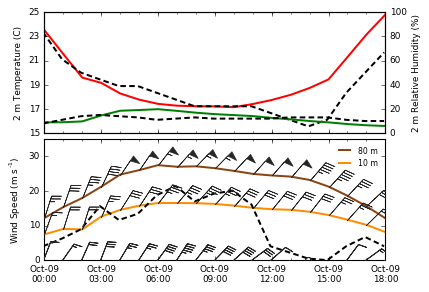

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Temperature
ax1.plot(TMP[0], TMP[1]-273.15, color='red')
ax1.plot(a['DATETIME'], a['air_temp'], linestyle='--', dashes=(5, 3), color='k')
ax1.set_ylabel('2 m Temperature (C)')
#ax1.xaxis.grid()
ax1.set_ylim([15,25])
ax1.set_yticks(range(15,26,2))

# Relative Humidity
ax1b = ax1.twinx()
ax1b.plot(RH[0], RH[1], color='green')
ax1b.set_ylim([0,100])
ax1b.set_ylabel('2 m Relative Humidity (%)')
ax1b.plot(a['DATETIME'], a['relative_humidity'], linestyle='--', dashes=(5, 3), color='k')

# Wind Speed
ax2.plot(UV80[0], UV80[3], color='saddlebrown', label='80 m')
ax2.plot(UV10[0], UV10[3], color='darkorange', label='10 m')
ax2.plot(a['DATETIME'], a['wind_speed'], linestyle='--', dashes=(5, 3), color='k')

# 10 m Wind Barbs
# Barbs can not take a datetime object, so find the date indexes
idx = mpl.dates.date2num(UV10[0])
for i, d in enumerate(idx):
    ax2.barbs(d, UV10[3][i], UV10[1][i], UV10[2][i],
              length=6.5, linewidth=.65, zorder=10,
              barb_increments=dict(half=2.5, full=5, flag=25), color=[.15,.15,.15])

# 80 m Wind Barbs
# Barbs can not take a datetime object, so find the date indexes
idx = mpl.dates.date2num(UV80[0])
for i, d in enumerate(idx):
    ax2.barbs(d, UV80[3][i], UV80[1][i], UV80[2][i],
              length=6.5, linewidth=.65, zorder=10,
              barb_increments=dict(half=2.5, full=5, flag=25), color=[.15,.15,.15])

# MesoWest Wind Barbs
# Barbs can not take a datetime object, so find the date indexes
idx = mpl.dates.date2num(a['DATETIME'])
for i, d in enumerate(idx):
    ax2.barbs(d, 0, MWu[i], MWv[i],
              length=6, linewidth=.85, zorder=10,
              barb_increments=dict(half=2.5, full=5, flag=25), color=[.15,.15,.15])

    
#ax2.xaxis.grid()
ax2.set_ylim([0,35])
ax2.set_yticks(range(0,40,10))
ax2.set_ylabel(r'Wind Speed (m s$\mathregular{^{-1}}$)')
ax2.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 3)))
ax2.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))

legend = ax2.legend(frameon=True, framealpha=.8, loc='best')
legend.get_frame().set_linewidth(0)

ax2.set_xlim([DATE, DATE+timedelta(hours=18)])

#ax1.set_title('%s HRRR forecast initialized %s' % (stn, DATE.strftime('%Y-%b-%d %H:%M UTC')))

plt.savefig('./figs/Fig_03_%s_forecast_initialized_%s' % (stn, DATE.strftime('%Y%m%d_%H%M_UTC')))

## Print values of each point 

In [8]:
print "Observed: HWKC1"
for i, D in enumerate(a['DATETIME']):
    print '%s\t%s' % (a['wind_speed'][i], D)

Observed: HWKC1
4.02	2017-10-08 23:56:00
6.26	2017-10-09 00:56:00
8.94	2017-10-09 01:56:00
15.64	2017-10-09 02:56:00
11.62	2017-10-09 03:56:00
13.41	2017-10-09 04:56:00
18.78	2017-10-09 05:56:00
21.46	2017-10-09 06:56:00
16.99	2017-10-09 07:56:00
19.22	2017-10-09 08:56:00
20.11	2017-10-09 09:56:00
16.09	2017-10-09 10:56:00
4.02	2017-10-09 11:56:00
2.23	2017-10-09 12:56:00
0.45	2017-10-09 13:56:00
0.0	2017-10-09 14:56:00
4.02	2017-10-09 15:56:00
6.7	2017-10-09 16:56:00
4.02	2017-10-09 17:56:00


In [9]:
print "HRRR: HWKC1"
for i, D in enumerate(UV10[0]):
    print '%s\t%s' % (UV10[3][i], D)

HRRR: HWKC1
7.45082139036	2017-10-09 00:00:00
9.0317370345	2017-10-09 01:00:00
8.89566931391	2017-10-09 02:00:00
12.5996969216	2017-10-09 03:00:00
14.5399129562	2017-10-09 04:00:00
15.7582133885	2017-10-09 05:00:00
16.5326288834	2017-10-09 06:00:00
16.5362340933	2017-10-09 07:00:00
16.4912833832	2017-10-09 08:00:00
16.2715962203	2017-10-09 09:00:00
15.7907128841	2017-10-09 10:00:00
15.1413148916	2017-10-09 11:00:00
14.7445174412	2017-10-09 12:00:00
14.5635106885	2017-10-09 13:00:00
13.9999142054	2017-10-09 14:00:00
13.0651067613	2017-10-09 15:00:00
11.7003674448	2017-10-09 16:00:00
10.2171693987	2017-10-09 17:00:00
8.1208652408	2017-10-09 18:00:00
